In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score # 정확도 함수

In [49]:
# 한글 깨짐 주의
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

### import

train, test, submission

In [50]:
train = pd.read_csv("C:/Users/user/Documents/python/Dacon/data/식수예측/4_최종병합본/0321_기상청_코로나_식수(train data)_병합본.csv", encoding = "cp949")
train = train[["일자","평균기온(℃)","강수량(mm)","일조합", "defcnt", "요일","본사정원수","본사휴가자수","본사출장자수","본사시간외근무명령서승인건수","현본사소속재택근무자수", "중식계", "석식계", "new_col(중식)","new_col(석식)","중식_2","중식_3","석식_2","석식_3","중식_1_CLEAN","석식_1_CLEAN"]]
train.columns

Index(['일자', '평균기온(℃)', '강수량(mm)', '일조합', 'defcnt', '요일', '본사정원수', '본사휴가자수',
       '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계', 'new_col(중식)',
       'new_col(석식)', '중식_2', '중식_3', '석식_2', '석식_3', '중식_1_CLEAN',
       '석식_1_CLEAN'],
      dtype='object')

In [51]:
test = pd.read_csv("C:/Users/user/Documents/python/Dacon/data/식수예측/4_최종병합본/0321_기상청_코로나_식수(test data)_병합본.csv", encoding = "cp949")
test = test[["일자","평균기온(℃)","강수량(mm)","일조합", "defcnt", "요일","본사정원수","본사휴가자수","본사출장자수","본사시간외근무명령서승인건수","현본사소속재택근무자수", "new_col(중식)","new_col(석식)","중식_2","중식_3","석식_2","석식_3","중식_1_CLEAN","석식_1_CLEAN"]]

test.columns

Index(['일자', '평균기온(℃)', '강수량(mm)', '일조합', 'defcnt', '요일', '본사정원수', '본사휴가자수',
       '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'new_col(중식)', 'new_col(석식)',
       '중식_2', '중식_3', '석식_2', '석식_3', '중식_1_CLEAN', '석식_1_CLEAN'],
      dtype='object')

In [52]:
submission = pd.read_csv("C:/Users/user/Documents/python/Dacon/data/식수예측/1_데이터 원본/sample_submission.csv")
submission.head()
submission_copy = submission.copy()

### 전처리

In [53]:
# 범주형을 수치형을 바꾸기 1 
train['요일']=train['요일'].factorize()[0]
train['new_col(중식)']=train['new_col(중식)'].factorize()[0]
train['new_col(석식)']=train['new_col(석식)'].factorize()[0]
train['중식_2']=train['중식_2'].factorize()[0]
train['중식_3']=train['중식_3'].factorize()[0]
train['석식_2']=train['석식_2'].factorize()[0]
train['석식_3']=train['석식_3'].factorize()[0]
train['중식_1_CLEAN']=train['중식_1_CLEAN'].factorize()[0]
train['석식_1_CLEAN']=train['석식_1_CLEAN'].factorize()[0]

train.head(3)

,일자,평균기온(℃),강수량(mm),일조합,defcnt,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,중식계,석식계,new_col(중식),new_col(석식),중식_2,중식_3,석식_2,석식_3,중식_1_CLEAN,석식_1_CLEAN
0,2016-02-01,-0.6,0.0,9.1,0,0,2601,50,150,238,...,1039,331,0,0,0,0,0,0,0,0
1,2016-02-02,-2.3,0.0,9.5,0,1,2601,50,173,319,...,867,560,0,0,1,1,1,1,0,1
2,2016-02-03,-1.7,0.0,9.5,0,2,2601,56,180,111,...,1017,573,0,0,2,2,2,2,1,0


In [54]:
# 범주형을 수치형을 바꾸기 1 
test['요일']=test['요일'].factorize()[0]
test['new_col(중식)']=test['new_col(중식)'].factorize()[0]
test['new_col(석식)']=test['new_col(석식)'].factorize()[0]
test['중식_2']=test['중식_2'].factorize()[0]
test['중식_3']=test['중식_3'].factorize()[0]
test['석식_2']=test['석식_2'].factorize()[0]
test['석식_3']=test['석식_3'].factorize()[0]
test['중식_1_CLEAN']=test['중식_1_CLEAN'].factorize()[0]
test['석식_1_CLEAN']=test['석식_1_CLEAN'].factorize()[0]

test.head(3)

,일자,평균기온(℃),강수량(mm),일조합,defcnt,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,new_col(중식),new_col(석식),중식_2,중식_3,석식_2,석식_3,중식_1_CLEAN,석식_1_CLEAN
0,2021-01-27,4.1,0.0,8.9,23686,0,2983,88,182,5,358,0,0,0,0,0,0,0,0
1,2021-01-28,1.4,0.0,7.3,23791,1,2983,104,212,409,348,0,1,1,1,1,1,0,1
2,2021-01-29,-2.3,0.0,9.2,23903,2,2983,270,249,0,294,0,1,2,2,2,2,0,0


### 모델링

#### 중식계

In [55]:
# 종속 / 독립변수 
feature_columns = list(train.columns.difference(["중식계", "석식계","일자", "defcnt", "new_col(석식)", "new_col(중식)", "강수량(mm)", "석식_1_CLEAN", "일조합", "중식_2","본사출장자수", "본사정원수"]))

X_train = train[feature_columns]  # 독립변수
X_train.head()

y_train = train["중식계"] # 종속변수
X_train

,본사시간외근무명령서승인건수,본사휴가자수,석식_2,석식_3,요일,중식_1_CLEAN,중식_3,평균기온(℃),현본사소속재택근무자수
0,238,50,0,0,0,0,0,-0.6,0
1,319,50,1,1,1,0,1,-2.3,0
2,111,56,2,2,2,1,2,-1.7,0
3,355,104,3,3,3,0,3,-0.2,0
4,34,278,4,4,4,0,4,1.3,0
...,...,...,...,...,...,...,...,...,...
1200,4,75,284,437,2,0,385,-0.4,391
1201,462,92,34,438,3,0,135,5.2,351
1202,1,255,27,439,4,2,362,7.0,303
1203,616,107,13,440,0,0,128,6.3,327


In [56]:
# VIF 확인 - 잘못된 변수 해석, 예측 정확도 하락 등을 야기
# 본사정원수와 본사출장자수의 vif가 > 10 였기 때문에 본사정원수, 본사출장자수 변수 제거
# vif 만족

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif = vif.sort_values("VIF Factor").reset_index(drop = True)
vif

,VIF Factor,features
0,1.215437,중식_1_CLEAN
1,2.071222,현본사소속재택근무자수
2,2.197068,본사시간외근무명령서승인건수
3,2.419320,본사휴가자수
4,2.555699,요일
5,2.688340,석식_2
6,2.837318,평균기온(℃)
7,3.980785,중식_3
8,4.401135,석식_3


In [57]:
# x_test
feature_columns = list(test.columns.difference(["중식계", "석식계","일자", "defcnt", "new_col(석식)", "new_col(중식)", "강수량(mm)", "석식_1_CLEAN", "일조합", "중식_2","본사출장자수", "본사정원수"]))

X_test = test[feature_columns]  # 독립변수
X_test.head()

,본사시간외근무명령서승인건수,본사휴가자수,석식_2,석식_3,요일,중식_1_CLEAN,중식_3,평균기온(℃),현본사소속재택근무자수
0,5,88,0,0,0,0,0,4.1,358
1,409,104,1,1,1,0,1,1.4,348
2,0,270,2,2,2,0,2,-2.3,294
3,538,108,3,3,3,0,3,7.5,322
4,455,62,4,4,4,0,4,0.4,314


##### 예측모델 
- LightGBM, RandomForestClassifier, XGBoost

In [58]:
X_TRAIN,X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_train,y_train, test_size=.2, random_state=42)

In [59]:
# 모델 fit
clf = xgb.XGBRegressor(n_estimators= 200, learning_rate=0.03, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
# clf = RandomForestClassifier(n_estimators= 200)
#voting_model = VotingClassifier(estimators=[ ('XGBoostClassifier', clf), ('RandomForestClassifier', random)], voting='soft')

clf.fit(X_TRAIN, Y_TRAIN)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
print("\nModel2 Score: ",clf.score(X_TEST,Y_TEST))
print("MAE:",mean_absolute_error(Y_TEST, clf.predict(X_TEST)))
#print("accuracy_score :", accuracy_score(Y_TEST,clf.predict(X_TEST)))


Model2 Score:  0.7255897908831899
MAE: 82.94463503509142


In [61]:
# 예측
y_pred=clf.predict(X_test)
y_pred

array([ 672.447  ,  991.4051 ,  932.1606 ,  889.6287 ,  900.5673 ,
        720.29065, 1028.6276 ,  845.4425 ,  928.8503 ,  902.7824 ,
        608.5708 ,  917.0748 ,  835.7311 ,  760.9863 , 1036.8591 ,
       1011.6602 ,  886.8325 ,  838.2149 ,  763.501  ,  891.9691 ,
        825.43085,  855.04944,  793.8547 ,  958.41364,  797.9282 ,
        906.26794,  885.88495,  773.7037 ,  950.4753 ,  867.2492 ,
        932.1401 ,  858.0899 ,  756.3151 ,  960.99304,  886.5224 ,
        932.2802 ,  886.4888 ,  751.22363,  985.421  ,  793.1228 ,
        928.52875,  899.74097,  759.55664,  996.9889 ,  808.123  ,
        921.9636 ,  861.9427 ,  760.5477 ,  989.28296,  793.13617],
      dtype=float32)

In [62]:
submission_copy["중식계"] = y_pred
submission_copy

,일자,중식계,석식계
0,2021-01-27,672.447021,0
1,2021-01-28,991.405090,0
2,2021-01-29,932.160583,0
3,2021-02-01,889.628723,0
4,2021-02-02,900.567322,0
5,2021-02-03,720.290649,0
6,2021-02-04,1028.627563,0
7,2021-02-05,845.442505,0
8,2021-02-08,928.850281,0
9,2021-02-09,902.782410,0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

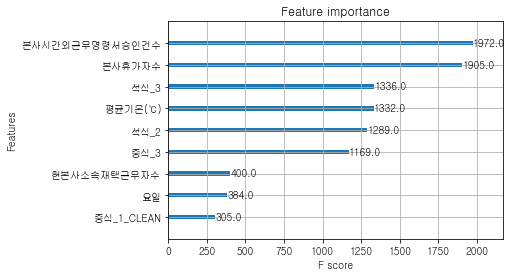

In [63]:
xgb.plot_importance(clf)

- 예측 정확도가 거의 0 이다

#### 석식계

##### 예측모델

In [24]:
# 종속 / 독립변수 
feature_columns = list(train.columns.difference(["중식계", "석식계","일자"," new_col(석식)", "new_col(중식)", "석식1CLEAN", "중식_2", "현본사소속재택근무자수","new_col(석식)","석식_1_CLEAN","본사정원수","본사출장자수"]))

X_train = train[feature_columns]  # 독립변수
X_train.head()

y_train = train["석식계"]  # 종속변수
X_train

,defcnt,강수량(mm),본사시간외근무명령서승인건수,본사휴가자수,석식_2,석식_3,요일,일조합,중식_1_CLEAN,중식_3,평균기온(℃)
0,0,0.0,238,50,0,0,0,9.1,0,0,-0.6
1,0,0.0,319,50,1,1,1,9.5,0,1,-2.3
2,0,0.0,111,56,2,2,2,9.5,1,2,-1.7
3,0,0.0,355,104,3,3,3,6.3,0,3,-0.2
4,0,0.0,34,278,4,4,4,9.6,0,4,1.3
...,...,...,...,...,...,...,...,...,...,...,...
1200,22852,0.0,4,75,284,437,2,8.9,0,385,-0.4
1201,22977,1.7,462,92,34,438,3,5.0,0,135,5.2
1202,23092,1.2,1,255,27,439,4,0.0,2,362,7.0
1203,23453,0.0,616,107,13,440,0,9.0,0,128,6.3


In [25]:
# VIF 확인 - 잘못된 변수 해석, 예측 정확도 하락 등을 야기
# 본사정원수와 본사정원자수,본사출장자수의 vif가 > 10 였기 때문에 본사정원수 변수 제거
# vif 만족

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif = vif.sort_values("VIF Factor").reset_index(drop = True)
vif

,VIF Factor,features
0,1.247552,중식_1_CLEAN
1,1.321863,강수량(mm)
2,1.750988,defcnt
3,2.461837,본사휴가자수
4,2.631177,석식_2
5,2.646460,본사시간외근무명령서승인건수
6,3.004263,요일
7,3.188349,평균기온(℃)
8,3.885362,중식_3
9,4.132239,일조합


In [26]:
# x_test
feature_columns = list(test.columns.difference(["중식계", "석식계","일자"," new_col(석식)", "new_col(중식)", "석식1CLEAN", "중식_2", "현본사소속재택근무자수","new_col(석식)","석식_1_CLEAN","본사정원수","본사출장자수"]))

X_test = test[feature_columns]  # 독립변수
X_test.head()

,defcnt,강수량(mm),본사시간외근무명령서승인건수,본사휴가자수,석식_2,석식_3,요일,일조합,중식_1_CLEAN,중식_3,평균기온(℃)
0,23686,0.0,5,88,0,0,0,8.9,0,0,4.1
1,23791,0.0,409,104,1,1,1,7.3,0,1,1.4
2,23903,0.0,0,270,2,2,2,9.2,0,2,-2.3
3,24262,16.0,538,108,3,3,3,0.3,0,3,7.5
4,24390,0.0,455,62,4,4,4,9.4,0,4,0.4


In [27]:
print(X_train.shape, y_train.shape)
X_TRAIN,X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_train,y_train, test_size=.2, random_state=42)
Y_TRAIN

(1205, 11) (1205,)


294     541
876     573
382     484
634     556
906     446
       ... 
1044    403
1095    520
1130    595
860     401
1126    412
Name: 석식계, Length: 964, dtype: int64

In [45]:
# 모델 fit
clf = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.05, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
clf.fit(X_TRAIN, Y_TRAIN)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
# 성능 평가
from sklearn.metrics import mean_absolute_error

print("\nModel2 Score: ",clf.score(X_TEST,Y_TEST))
print("MAE:",mean_absolute_error(Y_TEST, clf.predict(X_TEST)))


Model2 Score:  0.7176898500347918
MAE: 50.881221187559895


In [30]:
# 예측
y_pred=clf.predict(X_test)
y_pred

array([307.91742, 411.98825, 205.2436 , 447.20547, 454.5219 , 386.72394,
       461.60254, 368.09296, 529.03625, 501.7818 , 136.59024, 502.08365,
       523.45605, 399.7744 , 544.3375 , 432.0975 , 470.9631 , 563.16736,
       404.1004 , 506.46967, 273.2055 , 536.37537, 452.1161 , 560.1465 ,
       404.04877, 502.68732, 518.23737, 417.1558 , 518.9293 , 261.25446,
       488.40402, 510.9843 , 396.80362, 439.46368, 249.21333, 513.59   ,
       531.05426, 346.72592, 432.00937, 263.5423 , 460.69684, 493.8878 ,
       388.82584, 387.91312, 245.52083, 507.12036, 529.26794, 386.62915,
       450.913  , 265.20593], dtype=float32)

In [31]:
submission_copy["석식계"] = y_pred
submission_copy

,일자,중식계,석식계
0,2021-01-27,672.447021,307.917419
1,2021-01-28,991.405090,411.988251
2,2021-01-29,932.160583,205.243607
3,2021-02-01,889.628723,447.205475
4,2021-02-02,900.567322,454.521912
5,2021-02-03,720.290649,386.723938
6,2021-02-04,1028.627563,461.602539
7,2021-02-05,845.442505,368.092957
8,2021-02-08,928.850281,529.036255
9,2021-02-09,902.782410,501.781799


In [32]:
submission_copy.to_csv("C:/Users/user/Documents/python/Dacon/data/식수예측/5_제출용/2.XGBoost.csv", encoding = "utf8",index=False)

# save할 때, 먼저 csv로 저장하고 메모장에서 인코딩 형식 바꿔주면 됨

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

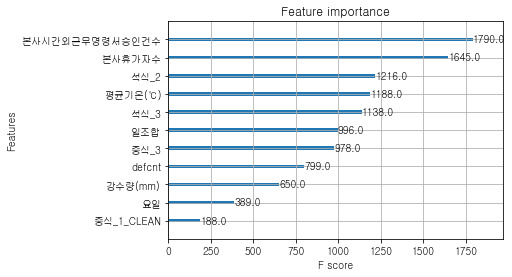

In [33]:
xgb.plot_importance(clf)

### 회귀분석 
- 오히려 단순선형회귀가 더 잘 나올수도 있어. . . -> 아니네

In [34]:
model = LinearRegression(n_jobs=-1)

In [35]:
model.fit(X_TRAIN, Y_TRAIN)

LinearRegression(n_jobs=-1)

In [36]:
pred = model.predict(X_test)
pred

array([392.86582322, 510.39892187, 354.59937143, 559.59632605,
       544.54715948, 392.14576159, 540.72032108, 373.60575446,
       606.43012434, 562.03311546, 300.70844876, 619.10048163,
       647.56526353, 383.17588334, 563.90493111, 375.40931782,
       648.94624931, 641.11298731, 381.40798478, 553.90979367,
       356.68700764, 623.47549726, 391.77152016, 608.90982252,
       383.54735197, 677.57890098, 704.6799334 , 384.24447017,
       572.05049224, 360.36998419, 647.723185  , 605.85394767,
       386.15171627, 540.09644179, 359.90319241, 597.99397678,
       603.76598073, 381.92456445, 516.9409379 , 348.11897791,
       587.33481819, 592.65459798, 382.59343139, 504.78383258,
       355.40159233, 598.01735868, 589.00019271, 383.27377966,
       536.62373982, 355.600879  ])

In [37]:
print("\nModel2 Score: ",clf.score(X_TEST,Y_TEST))
print("MAE:",mean_absolute_error(Y_TEST, clf.predict(X_TEST)))


Model2 Score:  0.7176898500347918
MAE: 50.881221187559895
